## Выполнил: Бобровских Глеб, ИАД-2

## Рекомендательные системы: предсказание оценки

Рассмотрим задачу предсказания оценки, которую пользователь поставит фильму. Особенность этой задачи в том, что объекты выборки описываются категориальными признаками, принимающими большое число значений (например: идентификатор пользователя, идентификатор фильма, тэги, киноперсоны).

Данные: [MovieLens + IMDb/Rotten Tomatoes](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-2k-v2.zip) ([описание](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-readme.txt)). Набор содержит данные о предпочтениях пользователей сервиса рекомендации кинофильмов [MovieLens](http://www.movielens.org/). Пользовательские оценки для фильмов принимают значения в интервале от 0.5 до 5.0, они записаны в файле *user_ratedmovies.dat* (а также в *user_ratedmovies-timestamps.dat*,  где для каждой оценки записана дата и время в формате timestamp), остальные файлы содержат дополнительную информацию о фильмах, которую можно использовать как признаки. Заметьте: кроме оценок (и тегов), про пользователя ничего не известно.

Задача: построить модель, предсказывающую оценку пользователя фильму, который он еще не смотрел.

Метрика качества: будем считать, что пользователю сервиса доступен блок рекомендаций, который может содержать рекомендации не более чем 5 фильмов.
Выберем некоторого пользователя $u$ и обозначим известные для него рейтинги за $R^u$. В качестве тестовых рейтингов $R^u_{test}$ для этого пользователя рассмотрим 5 рейтингов, поставленные последними по времени, в качестве валидационных $R^u_{val}$ — предпоследние 5 рейтингов. Остальные известные рейтинги этого пользователя будут составлять обучающую выборку $R^u_{train}$.
Для подбора гиперпараметров в рамках данного задания будем использовать валидационную выборку, предварительно обучив модель на обучающей выборке, а для финальной оценки качества — тестовую выборку, предварительно обучив модель на обучающей и валидационной выборках.

**1. (1 балл)** Загрузите данные и сформируйте 3 разреженные матрицы пользователи—фильмы для обучающих, валидационных и тестовых рейтингов пользователей соответственно, где в каждой ячейке стоит рейтинг, если он известен, или ноль, если неизвестен.

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
user_rate = pd.read_csv('user_ratedmovies-timestamps.dat', sep='\t')
user_rate.head()

,userID,movieID,rating,timestamp
0,75,3,1.0,1162160236000
1,75,32,4.5,1162160624000
2,75,110,4.0,1162161008000
3,75,160,2.0,1162160212000
4,75,163,4.0,1162160970000


In [3]:
users = user_rate.userID.unique()
movies = user_rate.movieID.unique()

In [4]:
user_rate = user_rate.sort_values(by='timestamp', ascending=False)

In [5]:
user_group = user_rate.groupby('userID')[['movieID', 'rating']].agg(lambda x: list(x))

In [6]:
for i, j in zip(['train', 'val', 'test'], [(10,-1), (5,10), (0,5)]):
    user_group[i+'_movies'] = user_group['movieID'].apply(lambda x: x[j[0]:j[-1]])
    user_group[i+'_rating'] = user_group['rating'].apply(lambda x: x[j[0]:j[1]])

In [11]:
def translate(x, dict_):    
    return np.vectorize(dict_.__getitem__)(x)
 
h = len(users)
w = len(movies)
    
dict_ = {x:y for x, y in zip(sorted(movies), np.arange(w))}

train = sparse.csr_matrix((h, w))
val = sparse.csr_matrix((h, w))
test = sparse.csr_matrix((h, w))


for i, row in enumerate(user_group.iterrows()):
    train[i, translate(row[1]['train_movies'], dict_)] = row[1]['train_rating']
    val[i, translate(row[1]['val_movies'], dict_)] = row[1]['val_rating']
    test[i, translate(row[1]['test_movies'], dict_)] = row[1]['test_rating']

/home/bobrg/anaconda3/lib/python3.5/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Качество рекомендаций: будем использовать метрики RMSE@k и nDCG@k для $k=5$, описанные ниже.

#### RMSE@k

Поскольку нас интересуют лишь фильмы, попавшие в блок рекомендаций, качество работы модели можно оценивать при помощи RMSE на $k$ фильмах с наибольшим предсказанным рейтингом, где $k$ — размер блока рекомендаций. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}$. Тогда RMSE@k:

$$ \text{RMSE@k}(u) = \sqrt{ \frac{1}{k} \sum_{i=1}^k (r_{u(i)} - \hat{r}_{u(i)})^2 },$$
$$ \text{RMSE@k} = \frac{1}{|U|} \sum_{u \in U} \text{RMSE@k}(u),$$
где $U$ — множество пользователей. При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

#### nDCG@k

Также можно использовать метрику качества ранжирования. Для этого для каждого пользователя $u$ предскажем оценку для всех фильмов из $R^u_{test}$ и отсортируем эти фильмы по убыванию предсказанного рейтинга. Ожидается, что хороший алгоритм должен выдать релевантные фильмы вверху списка. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}.$

Тогда nDCG@k :

$$\text{DCG@k}(u) = \sum_{i=1}^k g(r_{u(i)}) d(i),$$
$$\text{nDCG@k}(u) = \frac{\text{DCG@k}(u)}{\max \text{DCG@k}(u)},$$
$$\text{nDCG@k} = \frac{1}{|U|} \sum_{u \in U} \text{nDCG@k}(u),$$
где $g(r)$ — функция полезности фильма, а  $d(i)$ — штраф за позицию.

Положим $g(r) = 2^r-1, \, d(i) = \frac{1}{\log_2 (i+1)}.$ При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

**2. (2 балла)** Реализуйте функции rmse_score и ndcg_score, вычисляющие значения описанных выше метрик. Каждая из функций в качестве параметров должна принимать:
 * y_true — матрицу тестовых рейтингов (сформированную аналогично матрице тестовых рейтингов из предыдущего пункта; функция должна корректно работать и для разреженных, и для плотных матриц);
 * y_predicted — матрицу предсказаний модели в аналогичном формате (функция должна корректно работать и для разреженных, и для плотных матриц);
 * k — параметр $k$ в определениях метрик.

In [12]:
def rmse_score(y_true, y_predicted, k=5):
    if type(y_true) == sparse.csr.csr_matrix:
        y_true_ = y_true.toarray()
    else:
        y_true_ = y_true
    if type(y_predicted) == sparse.csr.csr_matrix:
        y_predicted_ = y_predicted.toarray()
    else:
        y_predicted_ = y_predicted
    rmse = 0
    for i, u in enumerate(y_predicted_):
        sort_arr = np.argsort(-u)
        rmse += np.sqrt(np.sum((u[sort_arr[:k]] - y_true_[i, sort_arr[:k]])**2)*1/k)
    
    return rmse/y_true.shape[0]
def ndcg_score(y_true, y_predicted, k=5):
    if type(y_true) == sparse.csr.csr_matrix:
        y_true_ = y_true.toarray()
    else:
        y_true_ = y_true
    if type(y_predicted) == sparse.csr.csr_matrix:
        y_predicted_ = y_predicted.toarray()
    else:
        y_predicted_ = y_predicted
    ndcg = []
    for i, u in enumerate(y_true_):
        sort_arr = np.argsort(-y_predicted_[i])
        dcg = sum((2**u[sort_arr][:5] - 1)*1/np.log2(i + 2))
        sort_arr = np.argsort(-y_true_[i])
        maxdcg = sum((2**u[sort_arr][:5] - 1)*1/np.log2(i + 2))
        ndcg.append(dcg/maxdcg)
    return sum(ndcg)/y_true.shape[0]

**3. (1 балл)** Постройте рекомендации на основе **most popular** метода, при котором предсказанный рейтинг для некоторого фильма $i$ одинаков для всех пользователей и совпадает со средним значением рейтинга по всем пользователям, оценившим этот фильм, и вычислите значения метрик RMSE@5 и nDCG@5 для тестовой матрицы из п. 1.

In [13]:
most_pop = np.zeros((test.shape[0], test.shape[1]))

most_pop = np.asarray((train.sum(1)/(train != 0).sum(1)))


In [14]:
rmse_score(test, most_pop, k=5)

1.5772933522982022

In [15]:
ndcg_score(test, most_pop, k=5)

0.0015667002251410634

** Наивный подход MOST POPULAR дает плохие результаты. **

**4. (1 балл)** Реализуйте построение рекомендаций путём разложения матрицы рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) (в предположении, что неизвестные рейтинги заменяются на нули) и последующего её восстановления и постройте график зависимости метрик RMSE@5 и nDCG@5 от значения ранга разложения на валидационной выборке (рассмотрите как минимум 10 различных значений ранга разложения)

In [11]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

In [486]:
svd = TruncatedSVD(n_components=1000, random_state=42)

In [487]:
tmp = svd.fit_transform(train)
inv = svd.inverse_transform(tmp)
scaler = MinMaxScaler((0, 5))
res = scaler.fit_transform(inv)

print('RMSE score:', rmse_score(test, res, k=5))
print('NDCG score:', ndcg_score(test, res, k=5))

RMSE score: 4.50630554277
NDCG score: 0.0


**Посмотрим теперь как будут меняться результаты в зависимости от ранга матрицы в разложении.** Метрики качества замерять будем на валидационной выборке, как того требует условие.

In [13]:
from tqdm import tqdm_notebook

In [15]:
rank = np.arange(10, 150, 10)
scores = []
results = []

for r in tqdm_notebook(rank):
    svd = TruncatedSVD(n_components=r)
    tmp = svd.fit_transform(train)
    inv = svd.inverse_transform(tmp)
    scaler = MinMaxScaler((0, 5))
    curr_res = scaler.fit_transform(inv)
    results.append(curr_res)
    scores.append([rmse_score(val, curr_res), ndcg_score(val, curr_res)])
    
res_scores = pd.DataFrame(scores, columns=['rmse', 'ndcg'])
res_scores

,rmse,ndcg
0,3.955701,0.000166
1,3.881971,0.000306
2,3.813015,0.000281
3,3.830712,0.000280
4,3.839991,0.000710
5,3.799078,0.000203
6,3.738582,0.000846
7,3.704352,0.000281
8,3.695034,0.000604
9,3.740955,0.000634


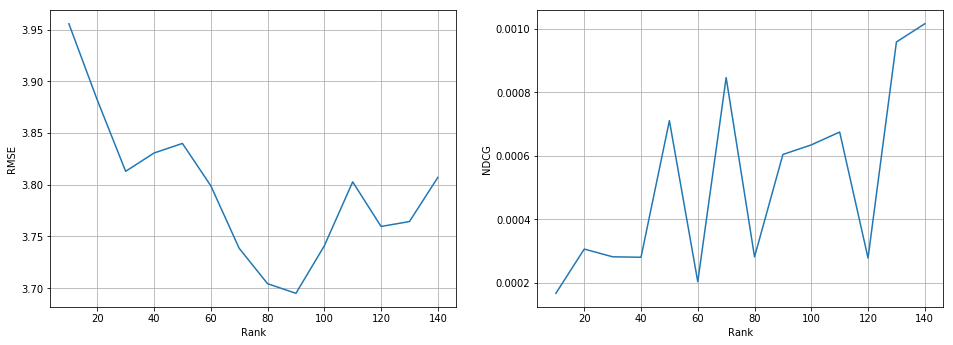

In [16]:
plt.figure(figsize=(16,12))
plt.subplot(2, 2, 1)
plt.plot(rank, np.array(scores)[:, 0])
plt.grid(True)
plt.xlabel('Rank')
plt.ylabel('RMSE')

plt.subplot(2, 2, 2)
plt.plot(rank, np.array(scores)[:, 1])
plt.grid(True)
plt.xlabel('Rank')
plt.ylabel('NDCG');


**Чем ближе n_components к число рейтингов исходной матрицы, тем лучше результат показывают метрики качества. Для хорошего результата хватает и rank=1500.**

**Подход к построению рекомендаций при помощи SVD без TruncatedSVD:** [подсмотрен тут](https://beckernick.github.io/matrix-factorization-recommender/)

In [17]:
from scipy.sparse.linalg import svds

In [19]:
U, sigma, Vt = svds(train, k = 100)

In [20]:
sigma = np.diag(sigma)

In [21]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

In [22]:
all_user_predicted_ratings

array([[ 0.04967805,  0.17314967,  0.19386913, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.28528374, -0.2161363 , -0.79822743, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03726491,  0.05583773,  0.02784913, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 1.60433734,  0.87934047, -0.02557251, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.32472801,  1.12184608,  0.25547621, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.92484008,  0.22839582,  0.35132819, ...,  0.        ,
         0.        ,  0.        ]])

In [23]:
rmse_score(val, all_user_predicted_ratings, k=5)

4.3593898335151273

In [24]:
ndcg_score(val, all_user_predicted_ratings, k=5)

0.0044889811924251222

**5. (3 балла)** Постройте рекомендации на основе user-based коллаборативной фильтрации. 
Предсказание модели $\hat{r}_{ui}$ вычисляйте по следующей формуле:
$$\hat{r}_{ui} = \bar{r}_{u} + \frac{\sum_{v \in U(u)} w_{uv} (r_{vi} - \bar{r}_v)}{\sum_{v \in U(u)} w_{uv}},$$
где $\bar{r}_u$ — средний ретинг пользователя $u$, $w_{uv}$ — мера сходства пользователей $u$ и $v$, $U(u) = \{ v \in U \, | \, w_{uv} > \alpha\}$ — коллаборация пользователя $u$. 

Значение параметра $\alpha$ возьмите равным 0.9.

Вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке.

In [25]:
import sklearn.preprocessing as pp

def cosine(mat):
    col_normed_mat = pp.normalize(mat.T.tocsc(), axis=0)
    return col_normed_mat.T * col_normed_mat

def pearson(mat):
    return np.corrcoef(mat.toarray())

def user_based(x, measure, alfa=0.9):
    r_ = np.zeros((x.shape[0], x.shape[1]))
    # подсчет средних
    means = np.asarray((x.sum(1)/(x != 0).sum(1)))
    # расчет матрицы схожести пользователей через кастомную функцию, которую передает пользователь
    w_uv = measure(x)
    
    if type(w_uv) == sparse.csr.csr_matrix:
        w_uv = w_uv.toarray()
    # убираем диагональные элементы, чтобы не учитывать сравнение пользователя с самим собой
    np.fill_diagonal(w_uv, 0)
    
    v = np.copy(x.toarray())
    w_uv[w_uv < alfa] = 0
    
    w_uv_sum = np.sum(w_uv, axis=0).reshape(-1, 1)
    w_uv_sum[w_uv_sum == 0] = 1
    w_uv_sum = 1/w_uv_sum
    
    # построение матрицы рекомендаций
    if np.sum(w_uv) != 0.0:
        r_ = means + np.dot(w_uv, (v - means))*w_uv_sum
    else:
        r_ = means

    return r_

Реализовал алгоритм без единого цикла! :)

**Посчитаем рекмендации с косинусной мерой сходства и $\alpha=0.9$.**

In [26]:
test_preds_cos=user_based(train, cosine, alfa=0.9)

In [27]:
rmse_score(test, test_preds_cos, k=5)

3.5460378286987324

In [28]:
ndcg_score(test, test_preds_cos, k=5)

0.0016551548533145616

**Посчитаем рекомендации с мерой Пирсона и $\alpha=0.9$.**

In [29]:
test_preds_pears=user_based(train, pearson, alfa=0.9)

In [30]:
rmse_score(test, test_preds_pears, k=5)

3.5460378286987324

In [31]:
ndcg_score(test, test_preds_pears, k=5)

0.0016551548533145616

**Теперь попробуем перебрать различные $\alpha$ и посмотреть как будут меняться метрики качества.**

In [33]:
scores = []

for a in tqdm_notebook(np.arange(0.1, 1.0, 0.1)):
    pred = user_based(train, cosine, alfa=a)
    scores.append([rmse_score(test, pred, k=5), ndcg_score(test, pred, k=5)])

In [34]:
results = pd.DataFrame(np.array(scores), columns=['rmse', 'ndcg'])
results

,rmse,ndcg
0,3.532371,0.009304
1,3.775879,0.005578
2,4.065188,0.004219
3,4.162585,0.003968
4,3.937849,0.002476
5,3.602189,0.001911
6,3.553400,0.001655
7,3.546038,0.001655
8,3.546038,0.001655


**Видим, что лучший результат NDCG@5 и лучший RMSE@5 достигаются при $\alpha=0.1$.**

**6. (1 балл)** Какой метод оказался лучше по каким метрикам? Почему?

**Most popular** дает очень плохие результаты. Данные метод выдает среднюю оценку для фильма, что является наивной идеей. Этот подход не учитывает индивидуальные предпочтения пользователя, в чем и выражается его основное слабое место. 

**SVD** - метод приближает исходную матрицу разложением на произведение трех других матриц. Показал себя чуть лучше, чем наивный алгоритм most popular, но все равно результаты неудовлетворительные.

**User-Based коллаборативная фильтрация** показала себя лучше прочих методов. Данный подход учитывает похожесть пользователей и делает более релевантные рекомендации, в чем и заключается основное преимуществе перед другими методами.

**7. (1 балл)** Приведите достоинства и недостатки используемых метрик. Какие еще метрики можно было бы использовать для решения задачи? Приведите примеры других постановок задачи, как в этом случае можно было бы оценить качество?

$RMSE$ - основным недостатоком является игнорирование порядка ранжирования и наличия верных рекомендаций на просмотр фильма. Ошибка в предсказании высокой оценки имеет такой же вес, что и ошибка в предсказании низкой оценки.Из достоинств - данную метрику предложил **Netflix**, а у них очень годные сериалы.

$nDCG$ - не штрафует за наличие фильмов с низким рейтингом и за фильмы, которые были бы релевантны, а в выдаче они отсутсвуют.

Допустим если нам нужно прогнозировать не оценку пользователя, а факт просмотра. Тогда для такой задачи более информативны метрики $precision@k$ или $HitRate@k$. 

В качестве метрик ранжиирования можно использовать precision и recall. Однако тут может возникнуть проблема отсутствия данных про рекомендованные объекты, которые пользователь не оценивал.

Задачу рекомендации можно переформулировать в задачу классификации (предсказание факта просмотра фильма пользователем) с предварительным отбором кандидатов контентной моделью. В качестве метрик взять:

* $precision@k$
* $HitRate@k$
* $nDCG@k$